In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Wrangling and load data
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

# feature selection
import explore
from explore import xgb_rank
from explore import merge_clusters2origdf
from explore import get_scaled_df

# model
import model

from model import create_kclusters
from model import run_models
# temporary - will take these out when I move function to explore.py
from model import filter_columns

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys 

import seaborn as sns


**Bring in the DataFrame, using prep_data to select whatever subset you want to inspect**

In [3]:
df = acquire_oil()

# different sub-group options
# horizontals only,   df = prep_data(df,direc='horizontal')
# single well leases only, df = prep_data(df,direc='horizontal')
# specific cluster, df = prep_data(df,clusterid=1) 

# everything in database - use this one when clustering,  df = prep_data(df)
df = prep_data(df)
df.shape

(8258, 59)

# Feature Selection

**XGBoost creates a ranked feature list used for feature selection in the models**
Let XGBoost reselect top features, regardless of which subgroup is being run

In [4]:
ranked_featurelist, ranked_scaledlist, allfeatures_rankdf = xgb_rank(df, df.recovery)

In [5]:
xfeatures = ranked_featurelist
yfeature = ['recovery']
scaled_df = get_scaled_df(df)

### Model Results - specific to the chosen sub-group and set of features

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 103.87992392081101
R2 score of training set is 0.27161923943759814


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.25810124 0.28594389 0.26218396]


The model performance for the test set
-------------------------------------------
RMSE of test set is 109.76380714260397
R2 score of test set is 0.2650972390604892




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 103.69869224929276
R2 score of training set is 0.2741585272512501


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.26134705 0.28722583 0.26541649]


The model performance for the test set
-------------------------------------------
RMSE of test set is 10

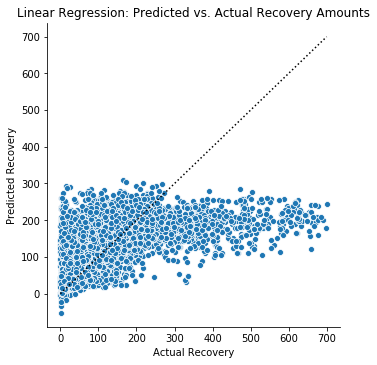

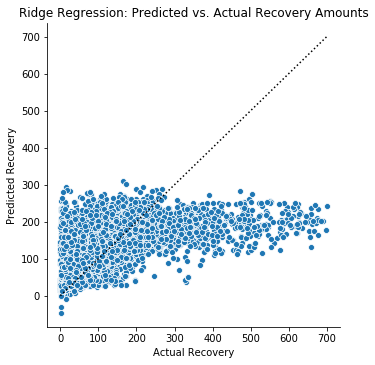

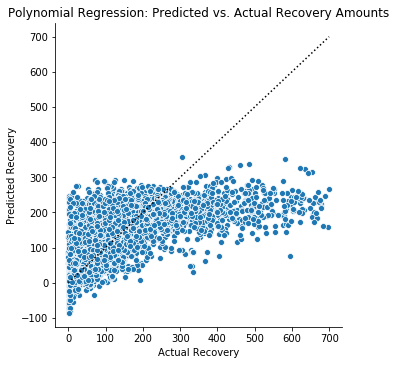

In [6]:
model.run_models(scaled_df, xfeatures, yfeature, 0.70)

**Now, build a new dataframe with an added column "clusterid"**

In [7]:
cluster_df = model.create_kclusters(scaled_df, ranked_featurelist, 3, 'clusterid')

**Let's see how many oberservations we have in each cluster**

# ALL Regression Types on Each Cluster